In [165]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time
import pickle

from util import *
import scanpy.api as sc
import data_loader as dl
import scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
output_folder = './figures/figure_tradeoff_posthoc_brain'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [167]:
## Read subsample parameters
fname = './figures/figure_tradeoff_curve/data/subsample_param.pickle'
f_myfile = open(fname, 'rb')
B_sub_list = pickle.load(f_myfile)
subsample_param_dic = pickle.load(f_myfile)
f_myfile.close()

# Generate a nice toy example (from 4k)

In [225]:
data = dl.load_10x_9k()
# mean_count = np.array(data.X.mean(axis=0)).reshape(-1)
# sort_idx = np.argsort(mean_count)[::-1]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [226]:
marker_gene_list= ['Lhx6','Rpp25','Npy','Sst','Nxph1','Gria1','Gria2','Dlx2','Dlx1','Cldn1','Col4a2','Col4a1',\
                  'Itm2a','Ccl4','Neurod1','Vtn','Igfbp4','Gadd45g','Hs6st2','Satb2','Jakmip1','Clmp','Nrp1',\
                  'S100a10','Pcp4','Rnd2','Mef2c','Ptprd','Ly6h','Camk2b','Meg3','Tbr1','Reln',\
                  'Cdk1','Cdkn2c','Pax6','Prox1']

gene_list = []
for gene in marker_gene_list:
    if gene in data.var_names:
#         print(gene,data[:,gene].X.mean())
        if data[:,gene].X.mean()>0.6:
            print(gene,data[:,gene].X.mean())
            gene_list.append(gene)
            Y = np.array(data[:,gene].X)
#             plt.figure()
#             plt.hist(Y,bins=50)
#             plt.show()

Gria2 4.285276
Neurod1 1.0087643
Gadd45g 0.85297984
Clmp 0.6976337
Nrp1 2.8648117
Pcp4 1.9129053
Rnd2 0.6795574
Mef2c 1.6161262
Ptprd 0.63792723
Ly6h 2.7261174
Meg3 5.4986854
Tbr1 0.64723927
Pax6 0.72283083


In [227]:
## Generate the toy example
Y = np.array(data[:,gene_list].X.todense()).astype(dtype=int)

p_true = np.ones([Y.shape[0]])
p_true = p_true / np.sum(p_true)
# x_true = Y / np.sum(Y) * Y.shape[0]

## Making each column of x to have the same mean 
# x_true = Y.copy()
x_true = Y / Y.mean(axis=0)
x_true = x_true/x_true.sum()*Y.shape[0]

## calculate the related quantities
M_true = np.zeros([2,x_true.shape[1]])
M_true[0] = np.mean(x_true,axis=0)
M_true[1] = np.mean(x_true**2,axis=0)
mean_true = x_true.mean(axis=0)
var_true = x_true.var(axis=0)
cv_true = np.sqrt(var_true)/mean_true
gamma_param_true = sd.M_to_gamma(M_true)

cov_true = np.cov(x_true.T)
_,V_true = np.linalg.eigh(cov_true)
PeCo_true = np.corrcoef(x_true.T)
p0_true = np.mean(x_true==0,axis=0)
kappa = 10
temp = np.exp(-kappa*x_true)
inactive_true = np.mean(temp,axis=0)
pairwise_inactive_true = temp.T.dot(temp)/temp.shape[0]
np.fill_diagonal(pairwise_inactive_true,inactive_true)
##
dist_true = {}
for i in range(Y.shape[1]):
    p_dist_true_1d = np.bincount(Y[:,i])
    p_dist_true_1d = p_dist_true_1d / np.sum(p_dist_true_1d)
    x_dist_true_1d = np.arange(p_dist_true_1d.shape[0])
    dist_true[i] = [p_dist_true_1d,x_dist_true_1d]

print('## cv_true',cv_true)
print('## PC_true')
print(PeCo_true)

print('## p0_true')
print(p0_true)

print('## inactive_true')
print(inactive_true)

print('## pairwise_inactive_true')
print(pairwise_inactive_true)

## cv_true [1.08086645 2.29301669 3.50117774 1.73035241 1.56785441 2.83079632
 2.01315434 2.5082751  1.77157508 1.3669762  2.51896814 1.81812092
 2.09872271]
## PC_true
[[ 1.          0.09847159 -0.10259586  0.48347617  0.47054424 -0.02813446
   0.06382124  0.00643929  0.23755857  0.25049797 -0.0535213   0.202796
  -0.15611941]
 [ 0.09847159  1.          0.07304256  0.01770208  0.20191454  0.17361417
   0.33431055 -0.10855581 -0.01542357  0.14616863 -0.04595254  0.18957503
   0.02882167]
 [-0.10259586  0.07304256  1.         -0.08401742 -0.09145085  0.01554123
   0.03405339 -0.0628135  -0.04005173 -0.06491591 -0.01933563 -0.00375343
   0.27474891]
 [ 0.48347617  0.01770208 -0.08401742  1.          0.43681121 -0.06238514
   0.08335828  0.14237557  0.1982423   0.27244182 -0.00451852  0.0767651
  -0.13579819]
 [ 0.47054424  0.20191454 -0.09145085  0.43681121  1.         -0.04733708
   0.24355009 -0.06350648  0.10163404  0.38905472  0.03326279  0.02167401
  -0.15550642]
 [-0.02813446  0.17

# Diagnosis

In [216]:
Nr = 2
Nc = 20000
data,size_factor = dl.poi_data_gen_nd(p_true,x_true,Nc=Nc, Nr=Nr,random_seed=0)

In [217]:
## cv 
M_ml,M_dd = sd.dd_1d_moment(data,verbose=False,size_factor=size_factor)
var_ml = sd.M_to_var(M_ml)
var_dd = sd.M_to_var(M_dd)
cv_ml = sd.M_to_cv(M_ml)
cv_dd = sd.M_to_cv(M_dd)
gamma_param_ml = sd.M_to_gamma(M_ml)
gamma_param_ml[0] /= Nr
gamma_param_dd = sd.M_to_gamma(M_dd)
gamma_param_dd[0] /= Nr

print('## mean_true',mean_true)
print('## mean_ml',M_ml[0]/Nr)
print('## mean_dd',M_dd[0]/Nr)
print('')

print('## var_true',var_true)
print('## var_ml',var_ml/Nr**2)
print('## var_dd',var_dd/Nr**2)
print('')

print('## cv_true',cv_true)
print('## cv_ml',cv_ml)
print('## cv_dd',cv_dd)
print('')

print('## gamma_true',gamma_param_true)
print('## gamma_ml',gamma_param_ml)
print('## gamma_dd',gamma_param_dd)


## mean_true [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
## mean_ml [0.07903273 0.07642763 0.08138199 0.07836921 0.07550165 0.07709914
 0.07512778 0.07505165 0.07652477 0.07647624 0.07421931 0.07503639
 0.07693196]
## mean_dd [0.07903273 0.07642763 0.08138199 0.07836921 0.07550165 0.07709914
 0.07512778 0.07505165 0.07652477 0.07647624 0.07421931 0.07503639
 0.07693196]

## var_true [0.00691285 0.03111199 0.072534   0.01771668 0.01454537 0.04741661
 0.02398101 0.03722748 0.01857088 0.01105695 0.03754557 0.01955955
 0.02606294]
## var_ml [0.04838747 0.07221871 0.12707495 0.05974833 0.05483704 0.09206211
 0.06160288 0.07540602 0.05946035 0.05119397 0.07809713 0.05691635
 0.06532875]
## var_dd [0.0068436  0.03235407 0.0844812  0.01888354 0.01564147 0.05159732
 0.02232915 0.03625506 0.01935118 0.0113056  0.03961951 0.01799875
 0.02521315]

## cv_true [1.08086645 2.29301669 3.50117774 1.73

In [218]:
## PC and PCA estimation
mean_ml,cov_ml,PeCo_ml = sd.ml_covariance(data,size_factor=size_factor,verbose=False)
mean_dd,cov_dd,PeCo_dd = sd.dd_covariance(data,size_factor=size_factor,verbose=False)

_,V_ml = np.linalg.eigh(cov_ml)
_,V_dd = np.linalg.eigh(cov_dd)


print('## cov_true')
print(cov_true)
print('## cov_ml')
print(cov_ml/Nr**2)
print('## cov_dd')
print(cov_dd/Nr**2)

print('')

print('## PeCo_true')
print(PeCo_true)
print('## PeCo_ml')
print(PeCo_ml)
print('## PeCo_dd')
print(PeCo_dd)

err_ml = np.log10(sd.cosine_distance(V_true[:,-1],V_ml[:,-1]))
err_dd = np.log10(sd.cosine_distance(V_true[:,-1],V_dd[:,-1]))
print('## PCA dir')
print('err_ml',err_ml)
print('err_dd',err_dd)

## cov_true
[[ 0.00691361  0.00144428 -0.00229761  0.00535109  0.00471888 -0.00050942
   0.00082182  0.00010331  0.00269193  0.00219027 -0.00086235  0.00235839
  -0.00209578]
 [ 0.00144428  0.03111539  0.00347023  0.00041565  0.00429577  0.00666902
   0.00913262 -0.00369485 -0.00037078  0.00271134 -0.00157073  0.00467705
   0.00082081]
 [-0.00229761  0.00347023  0.07254194 -0.00301217 -0.00297077  0.00091153
   0.00142041 -0.0032644  -0.00147013 -0.0018386  -0.00100915 -0.00014139
   0.0119472 ]
 [ 0.00535109  0.00041565 -0.00301217  0.01771862  0.00701286 -0.00180836
   0.00171839  0.00365684  0.00359626  0.00381356 -0.00011655  0.00142916
  -0.0029184 ]
 [ 0.00471888  0.00429577 -0.00297077  0.00701286  0.01454696 -0.0012433
   0.00454917 -0.00147795  0.00167057  0.00493444  0.00077741  0.00036562
  -0.0030281 ]
 [-0.00050942  0.00666902  0.00091153 -0.00180836 -0.0012433   0.04742181
   0.00655144 -0.00419568 -0.00110232  0.00696417  0.01675029  0.01106151
   0.00097369]
 [ 0.000821

In [229]:
Nr = 50
Nc = 1000
data,size_factor = dl.poi_data_gen_nd(p_true,x_true,Nc=Nc, Nr=Nr,random_seed=0)
    
p0_ml,p0_dd = sd.dd_inactive_prob(data,relative_depth=Nr/kappa,size_factor=size_factor,verbose=False)
pw_p0_ml,pw_p0_dd = sd.dd_pairwise_inactive_prob(data,relative_depth=Nr/kappa,size_factor=size_factor,verbose=False)
err_ml = np.log10(np.mean((p0_ml-inactive_true)**2)) - np.log10(np.mean(inactive_true**2))
err_dd = np.log10(np.mean((p0_dd-inactive_true)**2)) - np.log10(np.mean(inactive_true**2))

print('p0_true',p0_true[0:4])
print('inactive_true',inactive_true[0:4])
print('p0_ml',p0_ml[0:4])
print('p0_dd',p0_dd[0:4])
print('')
print('err_dd',err_dd)

# print('inactive_true',pairwise_inactive_true)
# print('pw_p0_ml',pw_p0_ml)
# print('pw_p0_dd',pw_p0_dd)

# print('err_ml',err_ml)
# print('err_dd',err_dd)

p0_true [0.22677476 0.67813322 0.74528922 0.63442156]
inactive_true [0.58721811 0.76034286 0.80616231 0.70878354]
p0_ml [0.307 0.688 0.741 0.609]
p0_dd [0.58788575 0.76916717 0.80095309 0.68319504]

err_dd -3.694500152505193


In [230]:
## distrbution estimation
# data,size_factor = dl.poi_data_gen_nd(p_true,x_true,sigma=0)
data,size_factor = dl.poi_data_gen_nd(p_true,x_true,sigma=0,Nc=Nc, Nr=10,random_seed=0)
for i_dim in range(data.shape[1]):
    Y = np.array(data[:,i_dim].X).astype(int)

    p_ml = np.bincount(Y)
    p_ml = p_ml / np.sum(p_ml)
    x_ml = np.arange(p_ml.shape[0])

    p_dd,x_dd = sd.dd_distribution(Y,gamma=None,verbose=False)
    
    p_true_,x_true_ = dist_true[i_dim]

    err_ml = dist_W1(p_true_,p_ml,x_true_,x_ml)
    err_dd = dist_W1(p_true_,p_dd,x_true_,x_dd)

    print('err_ml',err_ml)
    print('err_dd',err_dd)

err_ml 0.4233707140046659
err_dd 0.07122477968572409
err_ml 0.23398929010305586
err_dd 0.14501408399405238
err_ml 0.15307717812908658
err_dd 0.13011996604971118
err_ml 0.2412929215073552
err_dd 0.1826691650347205
err_ml 0.26351862749910304
err_dd 0.06392513821522208
err_ml 0.22322667959750334
err_dd 0.13306859541704388
err_ml 0.23716522055646305
err_dd 0.1690536177994755
err_ml 0.2429075643352391
err_dd 0.10047525400151543
err_ml 0.3371334283350032
err_dd 0.22018259031351306
err_ml 0.3293017292375894
err_dd 0.09514874218977357
err_ml 0.21866167658731855
err_dd 0.0834985398793636
err_ml 0.2750338646205073
err_dd 0.19131689032512472
err_ml 0.25566122213935805
err_dd 0.1727280988230786


# Simulation on the 9k-brain example

In [ ]:
n_rep = 20
G = len(gene_list)

test_list = ['mean','var','cv','gamma_theta','gamma_r','cov','PC','PCA','zero','pw_zero','dist']

## use a two-layer dic to store the result
err_ml_dic = {}
err_dd_dic = {}

for test_type in test_list:
    err_ml_dic[test_type] = {}
    err_dd_dic[test_type] = {}

Nc_list = [1000,5000,10000,30000,70000]
# Nc_list = [1000]
Nr_bar_list = [0.02,0.05,0.1, 0.2, 0.5, 1, 2, 5, 10]

start_time = time.time()

for Nc in Nc_list:
    for Nr_bar in Nr_bar_list:
        Nr = Nr_bar*G
        key_ = '%0.2f_%0.2f_%d'%(Nr_bar,Nr,Nc)
        for test_type in test_list:            
            err_ml_dic[test_type][key_] = []
            err_dd_dic[test_type][key_] = []
        
        print(key_)
        for i_rep in range(n_rep):
            
            ## Data generation
            data,size_factor = dl.poi_data_gen_nd(p_true,x_true,Nc=Nc,Nr=Nr,random_seed=i_rep)
            
            ## mean,var,cv 
            M_ml,M_dd = sd.dd_1d_moment(data,verbose=False,size_factor=size_factor)
            
            err_ml = np.log10(np.mean((mean_true-M_ml[0]/Nr)**2)) - np.log10(np.mean(mean_true**2))
            err_dd = np.log10(np.mean((mean_true-M_dd[0]/Nr)**2)) - np.log10(np.mean(mean_true**2))
            err_ml_dic['mean'][key_].append(err_ml)
            err_dd_dic['mean'][key_].append(err_dd)
            
            
            var_ml = sd.M_to_var(M_ml)
            var_dd = sd.M_to_var(M_dd)
            err_ml = np.log10(np.mean((var_true-var_ml/Nr**2)**2)) - np.log10(np.mean(var_true**2))
            err_dd = np.log10(np.mean((var_true-var_dd/Nr**2)**2)) - np.log10(np.mean(var_true**2))
            err_ml_dic['var'][key_].append(err_ml)
            err_dd_dic['var'][key_].append(err_dd)
            
            cv_ml = sd.M_to_cv(M_ml)
            cv_dd = sd.M_to_cv(M_dd)
            err_ml = np.log10(np.mean((cv_true-cv_ml)**2)) - np.log10(np.mean(cv_true**2))
            err_dd = np.log10(np.mean((cv_true-cv_dd)**2)) - np.log10(np.mean(cv_true**2))
            err_ml_dic['cv'][key_].append(err_ml)
            err_dd_dic['cv'][key_].append(err_dd)
            
            gamma_param_ml = sd.M_to_gamma(M_ml)
            gamma_param_ml[0] /= Nr
            gamma_param_dd = sd.M_to_gamma(M_dd)
            gamma_param_dd[0] /= Nr
            err_ml = np.log10(np.mean((gamma_param_true[0]-gamma_param_ml[0])**2))\
                     - np.log10(np.mean(gamma_param_true[0]**2))
            err_dd = np.log10(np.mean((gamma_param_true[0]-gamma_param_dd[0])**2))\
                     - np.log10(np.mean(gamma_param_true[0]**2))
            err_ml_dic['gamma_theta'][key_].append(err_ml)
            err_dd_dic['gamma_theta'][key_].append(err_dd)
            err_ml = np.log10(np.mean((gamma_param_true[1]-gamma_param_ml[1])**2))\
                     - np.log10(np.mean(gamma_param_true[1]**2))
            err_dd = np.log10(np.mean((gamma_param_true[1]-gamma_param_dd[1])**2))\
                     - np.log10(np.mean(gamma_param_true[1]**2))
            err_ml_dic['gamma_r'][key_].append(err_ml)
            err_dd_dic['gamma_r'][key_].append(err_dd)
            
            ## PC and PCA
            mean_ml,cov_ml,PeCo_ml = sd.ml_covariance(data,size_factor=size_factor,verbose=False)
            mean_dd,cov_dd,PeCo_dd = sd.dd_covariance(data,size_factor=size_factor,verbose=False,PC_prune=False)
            
            err_ml = np.log10(np.mean((cov_true-cov_ml/Nr**2)**2)) - np.log10(np.mean(cov_true**2))
            err_dd = np.log10(np.mean((cov_true-cov_dd/Nr**2)**2)) - np.log10(np.mean(cov_true**2))
            err_ml_dic['cov'][key_].append(err_ml)
            err_dd_dic['cov'][key_].append(err_dd)
            
            err_ml = np.log10(np.mean((PeCo_true-PeCo_ml)**2)) - np.log10(np.mean(PeCo_true**2))
            err_dd = np.log10(np.mean((PeCo_true-PeCo_dd)**2)) - np.log10(np.mean(PeCo_true**2))
            err_ml_dic['PC'][key_].append(err_ml)
            err_dd_dic['PC'][key_].append(err_dd)

            ## PCA
            _,V_ml = np.linalg.eigh(cov_ml)
            _,V_dd = np.linalg.eigh(cov_dd)
            err_ml = np.log10(sd.cosine_distance(V_true[:,-1],V_ml[:,-1]))
            err_dd = np.log10(sd.cosine_distance(V_true[:,-1],V_dd[:,-1]))            
            err_ml_dic['PCA'][key_].append(err_ml)
            err_dd_dic['PCA'][key_].append(err_dd)
            
            ## zero                        
            p0_ml,p0_dd = sd.dd_inactive_prob(data,relative_depth=Nr/kappa,size_factor=size_factor,verbose=False)
            err_ml = np.log10(np.mean((p0_ml-inactive_true)**2)) - np.log10(np.mean(inactive_true**2))
            err_dd = np.log10(np.mean((p0_dd-inactive_true)**2)) - np.log10(np.mean(inactive_true**2))
            err_ml_dic['zero'][key_].append(err_ml)
            err_dd_dic['zero'][key_].append(err_dd)
            
            ## pw zero
            pw_p0_ml,pw_p0_dd = sd.dd_pairwise_inactive_prob(data,relative_depth=Nr/kappa,\
                                                             size_factor=size_factor,verbose=False)
            err_ml = np.log10(sd.d_PC(pairwise_inactive_true,pw_p0_ml)) - np.log10(np.mean(pairwise_inactive_true**2))
            err_dd = np.log10(sd.d_PC(pairwise_inactive_true,pw_p0_dd)) - np.log10(np.mean(pairwise_inactive_true**2))
            err_ml_dic['pw_zero'][key_].append(err_ml)
            err_dd_dic['pw_zero'][key_].append(err_dd)

            
            ## distribution
            data,size_factor = dl.poi_data_gen_nd(p_true,x_true,sigma=0,Nc=Nc,Nr=Nr,random_seed=i_rep)
            err_ml,err_dd = 0,0
            for i_dim in range(data.shape[1]):
                Y = np.array(data[:,i_dim].X).astype(int)

                p_ml = np.bincount(Y)
                p_ml = p_ml / np.sum(p_ml)
                x_ml = np.arange(p_ml.shape[0])

                p_dd,x_dd = sd.dd_distribution(Y,gamma=None,verbose=False)

                p_true_,x_true_ = dist_true[i_dim]

                err_ml += dist_W1(p_true_,p_ml,x_true_,x_ml)/data.shape[1]
                err_dd += dist_W1(p_true_,p_dd,x_true_,x_dd)/data.shape[1]

            
            err_ml_dic['dist'][key_].append(np.log10(err_ml))
            err_dd_dic['dist'][key_].append(np.log10(err_dd))

# Save the data
fname = output_folder+'/data.pickle'
f_myfile = open(fname,'wb')
pickle.dump(err_ml_dic, f_myfile)
pickle.dump(err_dd_dic, f_myfile)
f_myfile.close()

print('total time: %0.1f'%(time.time()-start_time))

0.02_0.26_1000
0.05_0.65_1000
0.10_1.30_1000
0.20_2.60_1000
0.50_6.50_1000
1.00_13.00_1000
5.00_65.00_5000
10.00_130.00_5000
0.02_0.26_10000
0.05_0.65_10000
0.10_1.30_10000
0.20_2.60_10000
0.50_6.50_10000
1.00_13.00_10000
2.00_26.00_10000
5.00_65.00_10000
10.00_130.00_10000
0.02_0.26_30000
0.05_0.65_30000
0.10_1.30_30000
0.20_2.60_30000
0.50_6.50_30000
1.00_13.00_30000
2.00_26.00_30000
5.00_65.00_70000
10.00_130.00_70000
total time: 7850.9


In [66]:

# Read data statistics 
fname = output_folder+'/temp_data.pickle'
f_myfile = open(fname, 'rb')
err_ml_dic = pickle.load(f_myfile)
err_dd_dic = pickle.load(f_myfile)
f_myfile.close()

sd.plot_tradeoff_posthoc_curve(err_ml_dic['zero'],err_dd_dic['zero'],output_folder=output_folder,suffix='zero',\
                               ylabel='log10 MMSE (99.7 CI)',title='Inactive probability',\
                               ann_ml=-2,ann_dd=0)

FileNotFoundError: [Errno 2] No such file or directory: './figures/figure_tradeoff_posthoc/data/temp_data.pickle'

In [69]:
fname = output_folder+'/data/data.pickle'
f_myfile = open(fname, 'rb')
err_ml_dic = pickle.load(f_myfile)
err_dd_dic = pickle.load(f_myfile)
f_myfile.close()

In [72]:
for key in err_dd_dic['zero'].keys():
    print(key,err_dd_dic['zero'][key][2])

0.02_0.28_1000 -1.6053449423702133
0.05_0.70_1000 -2.0860604847446087
0.10_1.40_1000 -3.147987293229577
0.20_2.80_1000 -3.358279638915244
0.50_7.00_1000 -3.5798899938801765
1.00_14.00_1000 -3.944565090712805
2.00_28.00_1000 -3.995952784821708
5.00_70.00_1000 -2.640702383102243
10.00_140.00_1000 -1.710846929195081
0.02_0.28_5000 -1.6246530692549592
0.05_0.70_5000 -2.1759308664275223
0.10_1.40_5000 -3.6939019147173457
0.20_2.80_5000 -4.249220731435426
0.50_7.00_5000 -4.451772806581503
1.00_14.00_5000 -4.549032720884325
2.00_28.00_5000 -4.311675054826437
5.00_70.00_5000 -2.6359321758543954
10.00_140.00_5000 -1.7640223732256992
0.02_0.28_10000 -1.6115294982886004
0.05_0.70_10000 -2.183309645063722
0.10_1.40_10000 -3.646054768080718
0.20_2.80_10000 -4.265242416384158
0.50_7.00_10000 -4.776021925182941
1.00_14.00_10000 -4.837200528665964
2.00_28.00_10000 -4.397531206423663
5.00_70.00_10000 -2.691787315939303
10.00_140.00_10000 -1.7690730219158832
0.02_0.28_30000 -1.6215858792939062
0.05_0.70

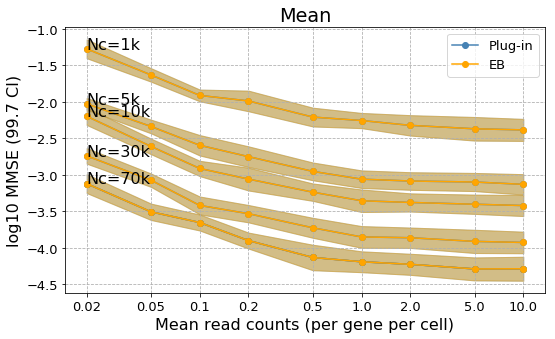

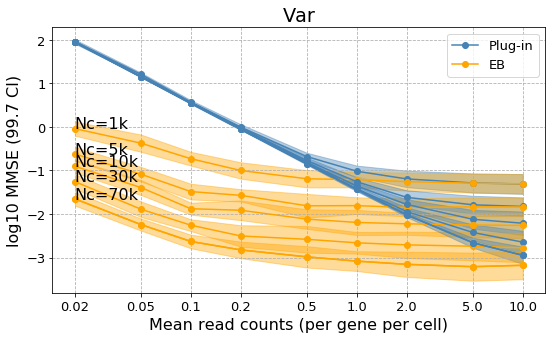

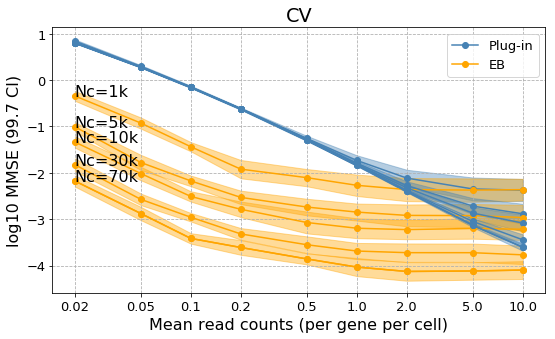

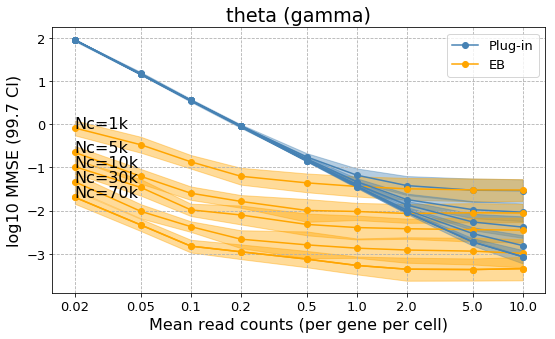

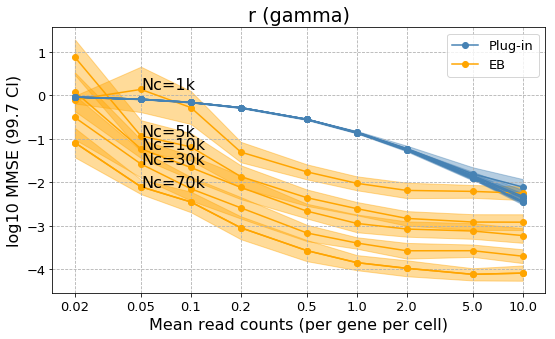

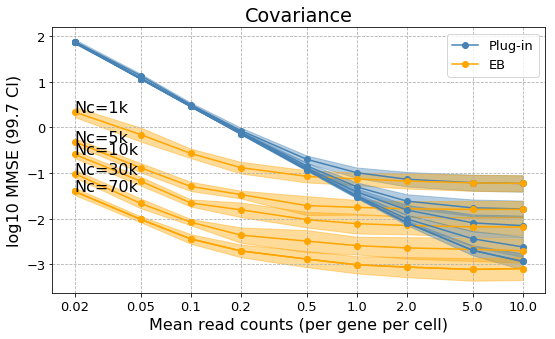

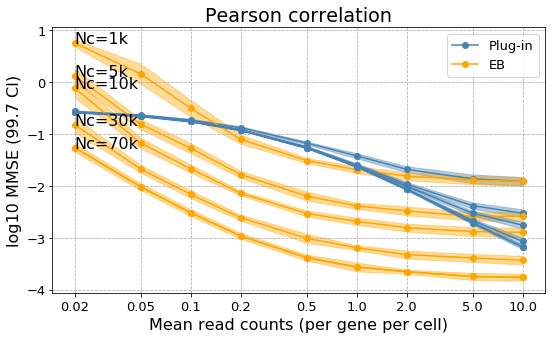

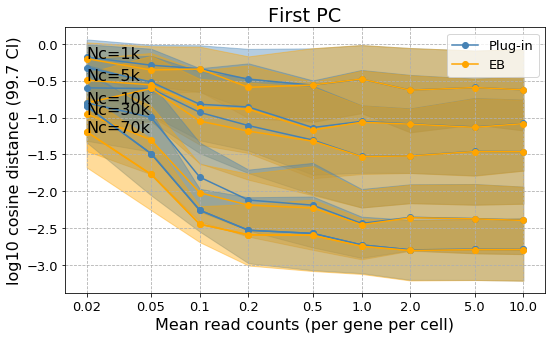

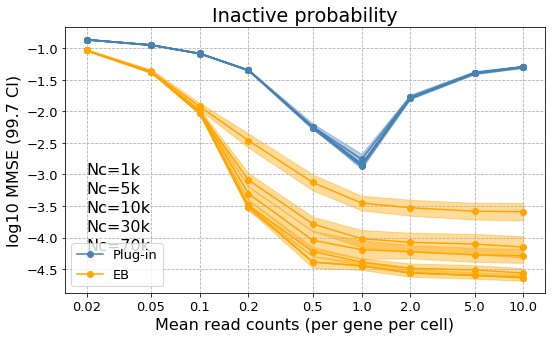

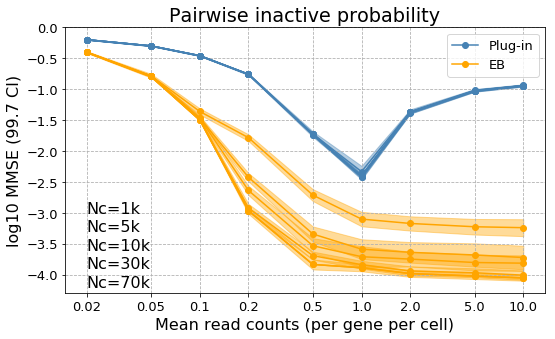

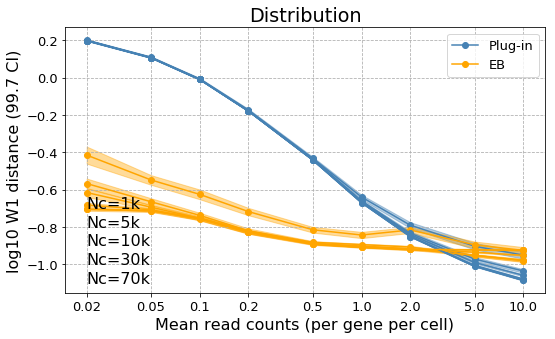

In [235]:
## Read data statistics 
fname = output_folder+'/data.pickle'
f_myfile = open(fname, 'rb')
err_ml_dic = pickle.load(f_myfile)
err_dd_dic = pickle.load(f_myfile)
f_myfile.close()

    

sd.plot_tradeoff_posthoc_curve(err_ml_dic['mean'],err_dd_dic['mean'],output_folder=output_folder,suffix='mean',\
                               ylabel='log10 MMSE (99.7 CI)',title='Mean',\
                               ann_ml=None,ann_dd=0)

sd.plot_tradeoff_posthoc_curve(err_ml_dic['var'],err_dd_dic['var'],output_folder=output_folder,suffix='var',\
                               ylabel='log10 MMSE (99.7 CI)',title='Var',\
                               ann_ml=None,ann_dd=0)

sd.plot_tradeoff_posthoc_curve(err_ml_dic['cv'],err_dd_dic['cv'],output_folder=output_folder,suffix='cv',\
                               ylabel='log10 MMSE (99.7 CI)',title='CV',\
                               ann_ml=None,ann_dd=0)

sd.plot_tradeoff_posthoc_curve(err_ml_dic['gamma_theta'],err_dd_dic['gamma_theta'],output_folder=output_folder,suffix='gamma_theta',\
                               ylabel='log10 MMSE (99.7 CI)',title='theta (gamma)',\
                               ann_ml=None,ann_dd=0)

sd.plot_tradeoff_posthoc_curve(err_ml_dic['gamma_r'],err_dd_dic['gamma_r'],output_folder=output_folder,suffix='gamma_r',\
                               ylabel='log10 MMSE (99.7 CI)',title='r (gamma)',\
                               ann_ml=None,ann_dd=1)

sd.plot_tradeoff_posthoc_curve(err_ml_dic['cov'],err_dd_dic['cov'],output_folder=output_folder,suffix='cov',\
                               ylabel='log10 MMSE (99.7 CI)',title='Covariance',\
                               ann_ml=None,ann_dd=0)

sd.plot_tradeoff_posthoc_curve(err_ml_dic['PC'],err_dd_dic['PC'],output_folder=output_folder,suffix='PC',\
                               ylabel='log10 MMSE (99.7 CI)',title='Pearson correlation',\
                               ann_ml=None,ann_dd=0)

sd.plot_tradeoff_posthoc_curve(err_ml_dic['PCA'],err_dd_dic['PCA'],output_folder=output_folder,suffix='PCA',\
                               ylabel='log10 cosine distance (99.7 CI)',title='First PC',\
                               ann_ml=None,ann_dd=0)

sd.plot_tradeoff_posthoc_curve(err_ml_dic['zero'],err_dd_dic['zero'],output_folder=output_folder,suffix='zero',\
                               ylabel='log10 MMSE (99.7 CI)',title='Inactive probability',\
                               ann_ml=None,ann_dd=None)

sd.plot_tradeoff_posthoc_curve(err_ml_dic['pw_zero'],err_dd_dic['pw_zero'],output_folder=output_folder,suffix='pw_zero',\
                               ylabel='log10 MMSE (99.7 CI)',title='Pairwise inactive probability',\
                               ann_ml=None,ann_dd=None)

sd.plot_tradeoff_posthoc_curve(err_ml_dic['dist'],err_dd_dic['dist'],output_folder=output_folder,suffix='dist',\
                               ylabel='log10 W1 distance (99.7 CI)',title='Distribution',\
                               ann_ml=None,ann_dd=None,ann_offset=-0.7,ann_step=0.1)



# old code

In [ ]:
B_list = []
    Nr_bar_list = []
    CI = 3
    for key_ in error_ml_dic.keys():
        B,Nr_bar,_,_ = key_to_param(key_)
        if B not in B_list: B_list.append(B)
        if Nr_bar not in Nr_bar_list: Nr_bar_list.append(Nr_bar)
    B_list = np.sort(np.array(B_list))
    Nr_bar_list = np.sort(np.array(Nr_bar_list))  
    n_Nr = Nr_bar_list.shape[0]
    
    plt.figure(figsize=[10,5])
    for B in B_list:
        err_ml = np.zeros([n_Nr])
        std_ml = np.zeros([n_Nr])
        err_dd = np.zeros([n_Nr])
        std_dd = np.zeros([n_Nr])
        
        for i_Nr,val_Nr in enumerate(Nr_bar_list):
            for key_ in error_ml_dic.keys():
                B_,Nr_bar_,_,_ = key_to_param(key_)
                if B == B_ and Nr_bar_ == val_Nr:
                    temp = len(error_ml_dic[key_])
                    err_ml[i_Nr] = np.array(error_ml_dic[key_]).mean()
                    std_ml[i_Nr] = np.array(error_ml_dic[key_]).std() / np.sqrt(temp)
                    err_dd[i_Nr] = np.array(error_dd_dic[key_]).mean()
                    std_dd[i_Nr] = np.array(error_dd_dic[key_]).std() / np.sqrt(temp)
                    
        #plt.plot(Nr_bar_list,err_ml,label='ml B=%dk'%int(B/1000),marker='o',color='steelblue')
        Nr_bar_list = np.array(Nr_bar_list)
        plt.plot(np.log10(Nr_bar_list),err_ml,marker='o',color='steelblue')
        plt.fill_between(np.log10(Nr_bar_list),err_ml-CI*std_ml,err_ml+CI*std_ml,alpha=0.4,color='steelblue')
        if ann_ml is not None:
            plt.annotate('B=%dk'%int(B/1000),[np.log10(Nr_bar_list[ann_ml]),err_ml[ann_ml]])
        #plt.plot(Nr_bar_list,err_dd,label='dd B=%dk'%int(B/1000),marker='o',color='orange')        
        plt.plot(np.log10(Nr_bar_list),err_dd,marker='o',color='orange')        
        plt.fill_between(np.log10(Nr_bar_list),err_dd-CI*std_dd,err_dd+CI*std_dd,alpha=0.4,color='orange')
        if ann_dd is not None:
            plt.annotate('B=%dk'%int(B/1000),[np.log10(Nr_bar_list[ann_dd]),err_dd[ann_dd]])
    
    #plt.xticks(np.arange(x_max+0.1, step=1))
    #plt.xlim([-0.1,x_max+0.1])
    if annotation is not None:
        for annon in annotation:
            text, loc = annon
            plt.annotate(text,loc)
            plt.scatter([loc[0]],[loc[1]],marker='^',color='red')
    
    plt.plot(np.log10(Nr_bar_list),err_ml,label='Plug-in',marker='o',color='steelblue')
    plt.plot(np.log10(Nr_bar_list),err_dd,label='EB',marker='o',color='orange')

    plt.xticks(np.log10(Nr_bar_list),Nr_bar_list)  
    plt.grid(linestyle='dashed')
    plt.xlabel('Mean read counts (per gene per cell)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(fontsize=16)
    plt.savefig(output_folder+'/tradeoff_curve_'+suffix+'.png')
    plt.savefig(output_folder+'/tradeoff_curve_'+suffix+'.pdf')
    plt.show()
    plt.close('all')